# Plot temperature response in years 2040 and 2100


This notebook plots temperature respons to SLCFs AND the total scenario forcing in a fixed nr of years

In [1]:
from IPython.core.display import display

from ar6_ch6_rcmipfigs.utils.badc_csv import write_badc_header

output_name = 'fig_dT_2040_2100_stacked_bar'

/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


In [2]:
import matplotlib.pyplot as plt

In [5]:
import pandas as pd

In [6]:
import xarray as xr
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

In [7]:
from ar6_ch6_rcmipfigs.utils.plot import get_cmap_dic
from ar6_ch6_rcmipfigs.utils.plot import get_var_nicename

In [8]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR, BASE_DIR

# PATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'
# PATH_DT = OUTPUT_DATA_DIR / '/dT_data_rcmip_models.nc'
# PATH_DT = OUTPUT_DATA_DIR / 'dT_data_RCMIP.nc'
PATH_DT = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation.nc'

#### Uncertainty data:

In [9]:
# PATH_DT_UNCERTAINTY = OUTPUT_DATA_DIR / 'dT_uncertainty_data_FaIR_chris.nc'
PATH_DT_UNCERTAINTY = OUTPUT_DATA_DIR / 'dT_uncertainty_data_FaIR_chris_ed02-3.nc'

## Set values:

In [10]:
# Years to plot:
years = [2040, 2100]

**Set reference year for temperature change:**

In [11]:
ref_year = 2019
ref_year_uncertainty = 2020

In [12]:
FIGURE_DIR = RESULTS_DIR / 'figures_recommendation/' / output_name



Create directories if not created. 

In [13]:
from pathlib import Path

Path(FIGURE_DIR).mkdir(parents=True, exist_ok=True)

#### Various definitions

In [14]:

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

recommendation = 'recommendation'
name_deltaT = 'Delta T'
sum_v = 'Sum SLCF (Aerosols, Methane, Ozone, HFCs)'


o3 = 'Ozone (O$_3$)'
ch4 = 'Methane (CH$_4$)'
HFCs = 'HFCs'

scenario_tot = 'Scenario total'

variables_erf_comp = [
    'aerosol-total-with_bc-snow',
    'ch4',
    'o3',
    'HFCs',
]

# total ERFs for anthropogenic and total:
variables_erf_tot = ['total_anthropogenic',
                     'total']
variables_all = variables_erf_comp + variables_erf_tot
# Scenarios to plot:

#### Scenarios:

In [15]:
scenarios_fl = ['ssp119',
                'ssp126',
                'ssp245',
                'ssp334',
                'ssp370',
                'ssp370-lowNTCF-aerchemmip',
                'ssp370-lowNTCF-gidden',
                'ssp585']
scenarios_fl_oneNTCF = ['ssp119',
                        'ssp126',
                        'ssp245',
                        'ssp370',
                        'ssp370-lowNTCF-aerchemmip',
                        # 'ssp370-lowNTCF-gidden',
                        'ssp585']

scenarios_fl_370 = ['ssp370', 'ssp370-lowNTCF-aerchemmip', 'ssp370-lowNTCF-gidden'  # Due to mistake here
                    ]

In [16]:
perc5 = '5th percentile'
perc95 = '95th percentile'

## Open dataset:

Open datasets generates in notebooks 1 - 2. 

In [17]:
ds_DT = xr.open_dataset(PATH_DT)
ds_uncertainty = xr.open_dataset(PATH_DT_UNCERTAINTY)

# make percentiles a dimension/coordinate: 

ds_uncertainty = ds_uncertainty.to_array('percentile', name=name_deltaT).to_dataset()

## Add sum of SLCFs as variable:

In [18]:
_str = ''
_vl = [get_var_nicename(var).split('(')[0].strip() for var in variables_erf_comp]
for var in _vl:
    _str += f'{var}, '

vn_sum = 'Sum SLCF (%s)' % _str[:-2]
print(vn_sum)

# _st = vn_sum.replace('(','').replace(')','').replace(' ','_').replace(',','')+'.csv'


_da_sum = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable)
_da_sum  # .assin_coord()
# _ds_check = ds_DT.copy()
ds_DT
# xr.concat([_ds_check[name_deltaT],_da_sum], dim=variable)

dd1 = _da_sum.expand_dims(
    {'variable': ['Sum SLCF (Aerosols, Methane, Ozone, HFCs)']})
# dd1=dd1.to_dataset()

ds_DT = xr.merge([ds_DT, dd1])

Sum SLCF (Aerosols, Methane, Ozone, HFCs)


## Various functions:

#### Filenames of output

In [19]:


def get_fn(var_name, s_y, e_y, ref_y, perc):
    _st = var_name.replace('(', '').replace(')', '').replace(' ', '_').replace(',', '')  # +'.csv'
    fn_out = f'{output_name}_{perc}_{_st}_{s_y}-{e_y}_refyear{ref_y}.csv'
    return fn_out

#### Rename variables to pretty names: 

In [20]:
from ar6_ch6_rcmipfigs.utils.plot import scn_dic

rn_dic = dict()
rn_dic_o = dict()
for v in variables_all:
    rn_dic[v] = get_var_nicename(v)
    rn_dic_o[get_var_nicename(v)] = v
rn_dic_o[scenario_tot] = 'scenario_total'
print(scenario_tot)

rn_dic_scen = scn_dic


def fix_names(df):
    df = df.rename(rn_dic)
    df = df.rename(rn_dic_scen, axis=1)
    return df

Scenario total


#### Function for creating table. 

In [21]:
def setup_table_prop(scenario_n='', yrs=None, _vlist=None, scens=None):
    if _vlist is None:
        _vlist = variables_erf_comp
    if yrs is None:
        yrs = [2040, 2100]
    if scens is None:
        scens = scenarios_fl
    its = [yrs, _vlist]
    _i = pd.MultiIndex.from_product(its, names=['', ''])
    table = pd.DataFrame(columns=scens, index=_i)  # .transpose()
    table.index.name = scenario_n
    return table

#### Extract values in tables: 

In [22]:


# tab_tot = setup_table2()
# tab_tot_sd = setup_table2()
def table_of_sts(_ds, _scn_fl, variables, tab_vars, _yrs, ref_yr, sts=recommendation):
    """
    Creates pandas dataframe of statistics (mean, standard deviation) for change
    in temperature Delta T since year (ref year) for each scenario in scenarios,

    :param _ds:
    :param _scn_fl:
    :param variables:
    :param tab_vars:
    :param _yrs:
    :param ref_yr:
    :param sts:
    :return:
    """
    tabel = setup_table_prop(yrs=_yrs, _vlist=tab_vars)
    for scn in _scn_fl:
        for _var, tabvar in zip(variables, tab_vars):
            # dtvar =  name_deltaT # if ERF name, changes it here.
            tabscn = scn  # Table scenario name the same.
            for year in _yrs:
                _da = _ds[name_deltaT].sel(scenario=scn, variable=_var)
                _da_refy = _da.sel(year=slice(ref_yr, ref_yr)).squeeze()  # ref year value
                _da_y = _da.sel(year=slice(year, year))  # year value
                _tab_da = _da_y - _da_refy
                tabel.loc[(year, tabvar), tabscn] = float(_tab_da.sel(percentile=sts).squeeze().values)  # [0]
    return fix_names(tabel)
    # return tabel

#### Write plotted data to file and add metadata to header

In [23]:
dic_head = dict(
    # title='Data for Figure 6.24, warming for SSP scenarios in year',
    last_revised_date='2021-06-29',
    location='global',
    reference='https://github.com/sarambl/AR6_CH6_RCMIPFIGS/',
    source='IPCC AR6 output',
    creator='Sara Marie Blichner (s.m.blichner@geo.uio.no)',

)
add_global_comments = [
    ['comments', 'G', 'This data is based on the AR6 forcing time series.'],
    ['comments', 'G', 'Please see https://github.com/sarambl/AR6_CH6_RCMIPFIGS for methods'],
]


def get_add_global_from_dic(_dic_head):
    add_global = [[key, 'G', _dic_head[key]] for key in _dic_head.keys()]
    add_global = add_global + add_global_comments
    return add_global


path_header_def = BASE_DIR / 'misc/header_empty.csv'
path_header_def.exists()


def to_csv_w_header(df, var_name, perc, _ref_year, end_year, ):
    fn_out = FIGURE_DIR / get_fn(var_name, _ref_year, end_year, _ref_year, perc)

    df.to_csv(fn_out)

    dic_head['title'] = get_title(perc, _ref_year, end_year)

    add_global = get_add_global_from_dic(dic_head)

    write_badc_header(fn_out, fn_out, add_global, default_unit='degrees C',
                      fp_global_default=path_header_def,
                      fp_var_default=path_header_def)

def get_title(perc, _ref_year, in_year):
    if perc == 'mean':
        txt = f'Data for Figure 6.24, warming for SSP scenarios in year {in_year}' \
              f' relative to year {_ref_year} '
    else:
        txt = f'Data for Figure 6.24, percentile {perc} warming in year {in_year} ' \
              f' relative to year {_ref_year}'

    return txt


def write_percentiles_to_file(_table_dT_anthrop,
                              _table_dT_slcfs,
                              _table_dT_anthrop_5th,
                              _table_dT_anthrop_95th,
                              _table_dT_sum_slcf_5,
                              _table_dT_sum_slcf_95
                              ):
    """
    Write plotted data to file
    :param _table_dT_anthrop:
    :param _table_dT_slcfs:
    :param _table_dT_anthrop_5th:
    :param _table_dT_anthrop_95th:
    :param _table_dT_sum_slcf_5:
    :param _table_dT_sum_slcf_95:
    :return:
    """

    _ls = [_table_dT_anthrop, _table_dT_slcfs]

    df_mean_merge = pd.concat(_ls)
    _ls = [_table_dT_anthrop_5th, _table_dT_sum_slcf_5]
    df_5th_merge = pd.concat(_ls)

    _ls = [_table_dT_anthrop_95th, _table_dT_sum_slcf_95]
    df_95th_merge = pd.concat(_ls)

    for y in years:
        df_y = df_mean_merge.loc[y].T
        df_y.index = df_y.index.rename('scenario')
        df_y = df_y.rename(rn_dic_o, axis=1)
        to_csv_w_header(df_y, '', 'mean', ref_year, y)
    for y in years:
        for perc, _df in zip(['5th-50th', '95th-50th'], [df_5th_merge, df_95th_merge]):
            df_y = _df.loc[y].T
            df_y.index = df_y.index.rename('scenario')
            df_y = df_y.rename(rn_dic_o, axis=1)
            to_csv_w_header(df_y, '', perc, ref_year_uncertainty, y)

### Extract tables to plot

In [24]:
tabel_dT_anthrop = table_of_sts(ds_DT, scenarios_fl, ['total_anthropogenic'], [scenario_tot], years, ref_year)
# 5th
tabel_dT_anthrop_5th = -table_of_sts(ds_uncertainty,
                                     scenarios_fl,
                                     ['total_anthropogenic'],
                                     [scenario_tot],
                                     years,
                                     ref_year_uncertainty,
                                     sts='p05-p50'
                                     )
# 95th

tabel_dT_anthrop_95th = table_of_sts(ds_uncertainty, scenarios_fl, ['total_anthropogenic'], [scenario_tot], years,
                                     ref_year_uncertainty,
                                     sts='p95-p50')


# Mean:
tabel_dT_slcfs = table_of_sts(ds_DT, scenarios_fl, variables_erf_comp, variables_erf_comp, years,
                              ref_year)

# Get percentiles for sum of SLCFs

tabel_dT_sum_slcf_5 = - table_of_sts(ds_uncertainty,
                                     scenarios_fl,
                                     [sum_v],
                                     ['Sum SLCFs'],
                                     years,
                                     ref_year_uncertainty,
                                     sts='p05-p50')
tabel_dT_sum_slcf_95 = table_of_sts(ds_uncertainty,
                                    scenarios_fl,
                                    [sum_v],
                                    ['Sum SLCFs'],
                                    years,
                                    ref_year_uncertainty,
                                    sts='p95-p50')

### colors

In [25]:
cdic = get_cmap_dic(variables_erf_comp)  # , palette='colorblind'):
ls = [cdic[key] for key in variables_erf_comp]

(0.5607843137254902, 0.0, 0.6470588235294118)
(1.0, 0.4196078431372549, 0.07450980392156863)
(0.5254901960784314, 0.7803921568627451, 0.29411764705882354)
(0.21568627450980393, 0.49411764705882355, 0.7215686274509804)


In [26]:

def plt_stacked(axs, _table_dT_anthrop, _table_dT_slcfs,
                _table_dT_anthrop_5th, _table_dT_anthrop_95th,
                _table_dT_sum_slcf_5, _table_dT_sum_slcf_95):
    tits = ['Change in GSAT in 2040 relative to 2019', 'Change in GSAT in 2100 relative to 2019']
    for _yr, _ax, _tit in zip(years, axs, tits):
        # Pick out year and do various renames:
        # Total antropogenic
        _tot_anthrop = _table_dT_anthrop.loc[_yr].rename(scn_dic, axis=1)
        # Sum SLCFs
        # uncertainty:
        bot = _table_dT_anthrop_5th.loc[_yr].rename(scn_dic, axis=1)
        top = _table_dT_anthrop_95th.loc[_yr].rename(scn_dic, axis=1)
        err_anthrop = pd.merge(bot, top, how='outer').values
        # Plot bars for anthropogenic total:
        _ax.barh(_tot_anthrop.transpose().index, _tot_anthrop.transpose()[scenario_tot].values,
                 color='k',
                 xerr=err_anthrop,
                 error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2),
                 label='Scenario total', alpha=.2,
                 )
        # Plot bars for SLCFs total:

        # Plot stacked plot of components:
        _tab = _table_dT_slcfs.loc[_yr].transpose().rename(
            {'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
        _tab = _tab.rename(scn_dic, axis=0)
        a = _tab.plot(kind='barh', stacked=True, ax=_ax, color=ls, legend=(_yr != 2040))  # , grid=True)#stac)
        tab_sum_all_slcf = _tab.sum(axis=1)  # , c=100)#.plot(kind='barh', )
        # ax.scatter(_t, list(_t.reset_index().index), zorder=10, c='w', marker='d')
        # uncertainty:
        bot = _table_dT_sum_slcf_5.loc[_yr].rename(scn_dic, axis=1)
        top = _table_dT_sum_slcf_95.loc[_yr].rename(scn_dic, axis=1)
        err_sum_slcf = pd.merge(bot, top, how='outer').values

        _ax.errorbar(tab_sum_all_slcf,
                     list(tab_sum_all_slcf.reset_index().index),
                     xerr=err_sum_slcf,
                     label='__nolabel__',
                     color='w',
                     fmt='d',
                     linestyle="None")  # ,

        if not _yr == 2040:
            _ax.legend(frameon=False, ncol=1)  # [l],labels=['Sce!!nario total'], loc = 4)#'lower right')
        # Zero line:
        _ax.axvline(0, linestyle='--', color='k', alpha=0.4)
        _ax.set_title(_tit)
        _ax.set_xlabel('Change in GSAT ($^\circ$C)')
        _ax.xaxis.set_minor_locator(MultipleLocator(.1))


def fix_axs(axs):
    ax = axs[0]

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(right=False, left=False)  # , color='w')

    ax = axs[1]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(labelleft=False, right=False, left=False, color='w')
    ax.tick_params(labelright=False, labelleft=False, right=False, left=False, color='w')
    ax.yaxis.set_visible(False)
    plt.tight_layout()

In [27]:
from matplotlib.ticker import MultipleLocator

## Main plot: 

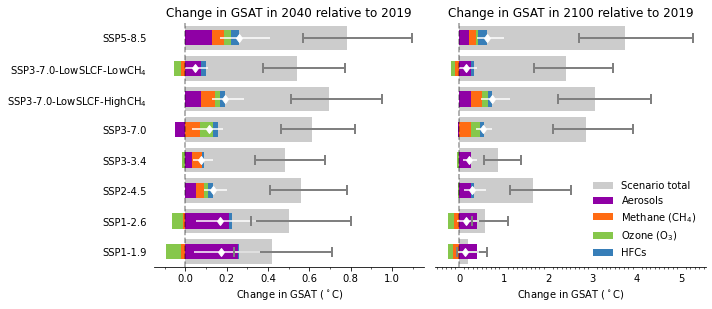

In [28]:
fig, axs = plt.subplots(1, len(years), figsize=[10, 4.4], sharex=False, sharey=True)
plt_stacked(axs, tabel_dT_anthrop, tabel_dT_slcfs, tabel_dT_anthrop_5th, tabel_dT_anthrop_95th,
            tabel_dT_sum_slcf_5, tabel_dT_sum_slcf_95)

fix_axs(axs)

write_percentiles_to_file(tabel_dT_anthrop, tabel_dT_slcfs, tabel_dT_anthrop_5th, tabel_dT_anthrop_95th,
                          tabel_dT_sum_slcf_5, tabel_dT_sum_slcf_95)

fn = FIGURE_DIR / output_name  # 'stack_bar_influence_years.png'
plt.tight_layout()
# ax = plt.gca()

plt.savefig(fn.with_suffix('.png'), dpi=300)
plt.savefig(fn.with_suffix('.pdf'), dpi=300)
plt.show()

In [29]:
for tab in [tabel_dT_anthrop, tabel_dT_slcfs]:
    display(tab)

,,SSP1-1.9,SSP1-2.6,SSP2-4.5,SSP3-3.4,SSP3-7.0,SSP3-7.0-LowSLCF-HighCH$_4$,SSP3-7.0-LowSLCF-LowCH$_4$,SSP5-8.5
,,,,,,,,,
2040,Scenario total,0.420935,0.502187,0.562209,0.481826,0.61491,0.696614,0.541559,0.781281
2100,Scenario total,0.196752,0.576662,1.645168,0.862185,2.843732,3.046661,2.403491,3.718987


SSP1-1.9  SSP1-2.6  SSP2-4.5  SSP3-3.4  SSP3-7.0  \
                                                                          
2040 Aerosols           0.25451  0.210743  0.050571  0.034456 -0.047187   
     Methane (CH$_4$) -0.020353 -0.010873  0.042229  0.048756  0.070685   
     Ozone (O$_3$)    -0.070592 -0.051027  0.015453 -0.014381  0.064835   
     HFCs              0.007461  0.017515  0.026536  0.007461  0.024436   
2100 Aerosols          0.390768  0.398195  0.258795  0.264948  -0.03259   
     Methane (CH$_4$) -0.136404 -0.129499  0.008606  0.004981  0.253615   
     Ozone (O$_3$)    -0.130242 -0.128863 -0.035455 -0.059085  0.217271   
     HFCs             -0.000936  0.001244  0.053756 -0.000936  0.087936   

                      SSP3-7.0-LowSLCF-HighCH$_4$ SSP3-7.0-LowSLCF-LowCH$_4$  \
                                                                               
2040 Aerosols                            0.074816                   0.074816   
     Methane (CH$_4$)                    0.070685                  -0.020829   
     Ozone (O$_3$)                       0.024497                  -0.031654   
     HFCs                                0.024436                   0.024487   
2100 Aerosols                            0.252303                   0.252303   
     Methane (CH$_4$)                    0.253615                  -0.101002   
     Ozone (O$_3$)                       0.144787                  -0.082406   
     HFCs                                0.087936                   0.076451   

                       SSP5-8.5  
                                 
2040 Aerosols          0.128671  
     Methane (CH$_4$)  0.057007  
     Ozone (O$_3$)     0.036518  
     HFCs              0.037495  
2100 Aerosols          0.220348  
     Methane (CH$_4$)  0.142298  
     Ozone (O$_3$)     0.055321  
     HFCs              0.200145

# Supplementary figues: 

### Without SSP3-3.4

In [30]:
all_scanarios = tabel_dT_anthrop.columns
subset_scenarios = [s for s in all_scanarios if s != 'SSP3-3.4']

tabel_dT_anthrop2 = tabel_dT_anthrop[subset_scenarios]
tabel_dT_slcfs2 = tabel_dT_slcfs[subset_scenarios]
tabel_dT_anthrop2_5th = tabel_dT_anthrop_5th[subset_scenarios]
tabel_dT_anthrop2_95th = tabel_dT_anthrop_95th[subset_scenarios]
tabel_dT_sum_slcf2_5 = tabel_dT_sum_slcf_5[subset_scenarios]
tabel_dT_sum_slcf2_95 = tabel_dT_sum_slcf_95[subset_scenarios]

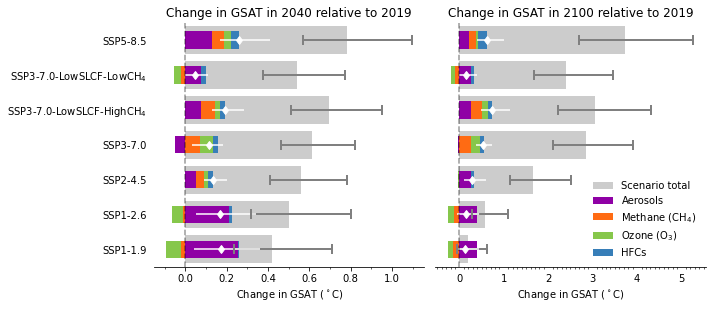

In [31]:
# noinspection PyRedeclaration
fig, axs = plt.subplots(1, len(years), figsize=[10, 4.4], sharex=False, sharey=True)
plt_stacked(axs, tabel_dT_anthrop2, tabel_dT_slcfs2, tabel_dT_anthrop2_5th, tabel_dT_anthrop2_95th,
            tabel_dT_sum_slcf2_5, tabel_dT_sum_slcf2_95)

fix_axs(axs)

# write_percentiles_to_file(tabel_dT_anthrop2, tabel_dT_slcfs2, tabel_dT_anthrop_5th, tabel_dT_anthrop_95th,
#            tabel_dT_sum_slcf_5, tabel_dT_sum_slcf_95)


fn = FIGURE_DIR / (output_name + 'no_ssp334')  # 'stack_bar_influence_years.png'
plt.tight_layout()
# ax = plt.gca()

plt.savefig(fn.with_suffix('.png'), dpi=300)
plt.savefig(fn.with_suffix('.pdf'), dpi=300)
plt.show()

### Without lowNTCF

In [32]:

scen_no_lowNTCF = [scn for scn in scenarios_fl if 'lowNTCF' not in scn]
print(scen_no_lowNTCF)

['ssp119', 'ssp126', 'ssp245', 'ssp334', 'ssp370', 'ssp585']


In [33]:
subset_scenarios = list(pd.Series(scenarios_fl_oneNTCF).replace(rn_dic_scen))

In [37]:
tabel_dT_anthrop2 = tabel_dT_anthrop[subset_scenarios]
tabel_dT_slcfs2 = tabel_dT_slcfs[subset_scenarios]
tabel_dT_anthrop2_5th = tabel_dT_anthrop_5th[subset_scenarios]
tabel_dT_anthrop2_95th = tabel_dT_anthrop_95th[subset_scenarios]
tabel_dT_sum_slcf2_5 = tabel_dT_sum_slcf_5[subset_scenarios]
tabel_dT_sum_slcf2_95 = tabel_dT_sum_slcf_95[subset_scenarios]

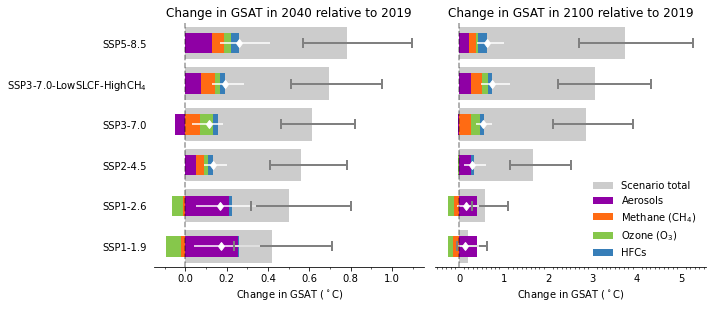

In [35]:

fig, axs = plt.subplots(1, len(years), figsize=[10, 4.4], sharex=False, sharey=True)
plt_stacked(axs, tabel_dT_anthrop2, tabel_dT_slcfs2, tabel_dT_anthrop2_5th,
            tabel_dT_anthrop2_95th, tabel_dT_sum_slcf2_5, tabel_dT_sum_slcf2_95)

fix_axs(axs)
fn = FIGURE_DIR / 'stack_bar_influence_years_one_lowNTCF.png'
plt.tight_layout()
ax = plt.gca()

plt.savefig(fn, dpi=300)
plt.savefig(fn.with_suffix('.pdf'), dpi=300)

plt.show()

### Without lowNTCF

In [36]:
# tabel_dT_anthrop2 = tabel_dT_anthrop[scen_no_lowNTCF]
# tabel_dT_slcfs2 = tabel_dT_slcfs[scen_no_lowNTCF]

subset_scenarios = list(pd.Series(scen_no_lowNTCF).replace(rn_dic_scen))

In [40]:
tabel_dT_anthrop2 = tabel_dT_anthrop[subset_scenarios]
tabel_dT_slcfs2 = tabel_dT_slcfs[subset_scenarios]
tabel_dT_anthrop2_5th = tabel_dT_anthrop_5th[subset_scenarios]
tabel_dT_anthrop2_95th = tabel_dT_anthrop_95th[subset_scenarios]
tabel_dT_sum_slcf2_5 = tabel_dT_sum_slcf_5[subset_scenarios]
tabel_dT_sum_slcf2_95 = tabel_dT_sum_slcf_95[subset_scenarios]

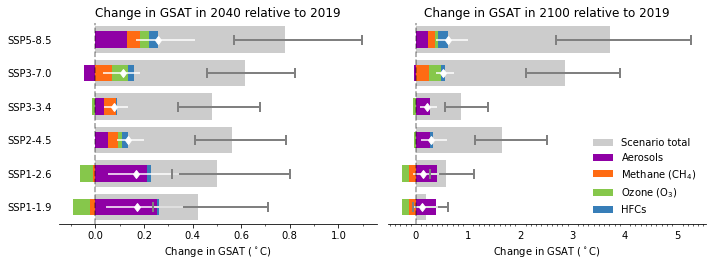

In [38]:

fig, axs = plt.subplots(1, len(years), figsize=[10, 3.8], sharex=False, sharey=True)
plt_stacked(axs, tabel_dT_anthrop2, tabel_dT_slcfs2, tabel_dT_anthrop2_5th,
            tabel_dT_anthrop2_95th, tabel_dT_sum_slcf2_5, tabel_dT_sum_slcf2_95)

fix_axs(axs)

fn = FIGURE_DIR / 'stack_bar_influence_years_no_lowNTCF.png'
plt.tight_layout()

plt.savefig(fn, dpi=300)
plt.savefig(fn.with_suffix('.pdf'), dpi=300)

### 3-7.0 only 

In [39]:

scenario_370 = [sc for sc in scenarios_fl if 'ssp370' in sc]
subset_scenarios = list(pd.Series(scenario_370).replace(rn_dic_scen))

In [34]:

tabel_dT_anthrop2 = tabel_dT_anthrop[subset_scenarios]
tabel_dT_slcfs2 = tabel_dT_slcfs[subset_scenarios]
tabel_dT_anthrop2_5th = tabel_dT_anthrop_5th[subset_scenarios]
tabel_dT_anthrop2_95th = tabel_dT_anthrop_95th[subset_scenarios]
tabel_dT_sum_slcf2_5 = tabel_dT_sum_slcf_5[subset_scenarios]
tabel_dT_sum_slcf2_95 = tabel_dT_sum_slcf_95[subset_scenarios]

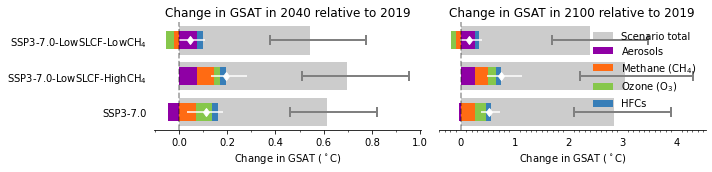

In [41]:

fig, axs = plt.subplots(1, len(years), figsize=[10, 2.5], sharex=False, sharey=True)

plt_stacked(axs, tabel_dT_anthrop2, tabel_dT_slcfs2, tabel_dT_anthrop2_5th,
            tabel_dT_anthrop2_95th, tabel_dT_sum_slcf2_5, tabel_dT_sum_slcf2_95)

fix_axs(axs)

fn = FIGURE_DIR / 'stack_bar_influence_years_horiz_errTot_370only.png'

plt.tight_layout()

plt.savefig(fn, dpi=300)
plt.savefig(fn.with_suffix('.pdf'), dpi=300)